In [ ]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 29.6 MB/s eta 0:00:00


In [ ]:
from gym import Env # import Env
import numpy as np
from gym.spaces import MultiDiscrete, Box
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [ ]:
import numpy as np
from gym import Env
from gym.spaces import Box, MultiDiscrete

class MultiRobotGridEnv(Env):
    def __init__(self, grid_size=(10, 10), num_robots=2, num_obstacles=5, dynamic_obstacle_freq=10):
        super(MultiRobotGridEnv, self).__init__()
        self.grid_size = grid_size
        self.num_robots = num_robots
        self.num_obstacles = num_obstacles
        self.dynamic_obstacle_freq = dynamic_obstacle_freq  # How often obstacles move

        self.action_space = MultiDiscrete([8] * num_robots)  # 8 actions per robot (8 directions)
        self.observation_space = Box(low=0, high=max(grid_size),
                                     shape=(num_robots * 2 + num_robots * 2,),  # 2 positions per robot: x, y
                                     dtype=np.int32)

        self.reset()

    def reset(self):
        self.robot_positions = [self._random_empty_cell() for _ in range(self.num_robots)]
        self.goal_positions = [self._random_empty_cell() for _ in range(self.num_robots)]

        # Initialize obstacles
        self.obstacles = []
        while len(self.obstacles) < self.num_obstacles:
            obstacle = self._random_empty_cell()
            if obstacle not in self.robot_positions and obstacle not in self.goal_positions:
                self.obstacles.append(obstacle)

        # Track visited cells
        self.visited_cells = [set() for _ in range(self.num_robots)]

        return self._get_obs()

    def _random_empty_cell(self):
        return (np.random.randint(0, self.grid_size[0]), np.random.randint(0, self.grid_size[1]))

    def move_dynamic_obstacles(self):
        """Move obstacles periodically."""
        if np.random.random() < 1 / self.dynamic_obstacle_freq:
            idx = np.random.randint(len(self.obstacles))
            old_pos = self.obstacles[idx]
            new_pos = self._random_empty_cell()
            while new_pos == old_pos or new_pos in self.robot_positions or new_pos in self.goal_positions:
                new_pos = self._random_empty_cell()
            self.obstacles[idx] = new_pos

    def step(self, actions):
        rewards = []
        done = []
        self.move_dynamic_obstacles()  # Update obstacles during each step

        # Direction vectors for 8-way movement
        directions = [(-1, 0),  # Up
                      (1, 0),   # Down
                      (0, -1),  # Left
                      (0, 1),   # Right
                      (-1, -1), # Up-Left
                      (-1, 1),  # Up-Right
                      (1, -1),  # Down-Left
                      (1, 1)]   # Down-Right

        for i, action in enumerate(actions):
            x, y = self.robot_positions[i]
            dx, dy = directions[action]

            # Calculate the new position
            new_pos = (x + dx, y + dy)

            reward = -0.1  # Step penalty

            if (0 <= new_pos[0] < self.grid_size[0] and
                0 <= new_pos[1] < self.grid_size[1] and
                new_pos not in self.obstacles):

                self.robot_positions[i] = new_pos

                # Check for revisiting penalty
                if new_pos in self.visited_cells[i]:
                    reward -= 2  # Revisiting penalty
                self.visited_cells[i].add(new_pos)

                # Check for reaching the goal
                if self.robot_positions[i] == self.goal_positions[i]:
                    reward += 10
                    done.append(True)
                else:
                    done.append(False)
            else:
                reward -= 1  # Collision penalty
                done.append(False)

            rewards.append(reward)

        return self._get_obs(), sum(rewards), all(done), {}

    def _get_obs(self):
        """Return the observation for the robots."""
        # Concatenate positions of robots and goals
        obs = []
        for i in range(self.num_robots):
            obs.extend(list(self.robot_positions[i]))  # Robot position (x, y)
            obs.extend(list(self.goal_positions[i]))    # Goal position (x, y)
        return np.array(obs)

# Example usage:
env = MultiRobotGridEnv(grid_size=(10, 10), num_robots=2, num_obstacles=5, dynamic_obstacle_freq=10)
obs = env.reset()
print("Initial Observation:", obs)

# Sample step for robots moving in different directions
actions = [0, 4]  # Robot 1 moves Up, Robot 2 moves Up-Left
obs, reward, done, info = env.step(actions)
print("Next Observation:", obs)
print("Reward:", reward)
print("Done:", done)


Initial Observation: [4 9 2 9 7 2 9 1]
Next Observation: [3 9 2 9 6 1 9 1]
Reward: -0.2
Done: False


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
!pip install shimmy

In [ ]:
import numpy as np
import heapq

# Directions for 8-way movement (up, down, left, right, and diagonals)
directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

def is_valid_move(x, y, grid):
    """Check if the move is within bounds and not an obstacle."""
    return 0 <= x < len(grid) and 0 <= y < len(grid[0]) and grid[x][y] == 0

def astar_single_robot(start, goal, grid, other_robot_path=None):
    """A* for a single robot, avoiding obstacles and other robots."""
    # Min-heap priority queue
    open_list = []
    heapq.heappush(open_list, (0, start))

    # Costs to get to each node
    g_costs = {start: 0}
    f_costs = {start: np.linalg.norm(np.array(start) - np.array(goal))}

    # Dictionary to store the parent of each node
    came_from = {}

    while open_list:
        _, current = heapq.heappop(open_list)

        # If the goal is reached, reconstruct the path
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.reverse()
            return path

        for dx, dy in directions:
            neighbor = (current[0] + dx, current[1] + dy)

            if not is_valid_move(neighbor[0], neighbor[1], grid):
                continue

            if other_robot_path and neighbor in other_robot_path:
                continue  # Avoid collision with the other robot's path

            tentative_g_cost = g_costs[current] + 1

            if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                g_costs[neighbor] = tentative_g_cost
                f_costs[neighbor] = tentative_g_cost + np.linalg.norm(np.array(neighbor) - np.array(goal))
                heapq.heappush(open_list, (f_costs[neighbor], neighbor))
                came_from[neighbor] = current

    return []  # No valid path found

def astar(start1, start2, goal1, goal2, grid):
    """A* Pathfinding for Two Robots."""
    # Pathfinding for the first robot
    path1 = astar_single_robot(start1, goal1, grid)

    if not path1:
        return [], []  # No path found for the first robot

    # Pathfinding for the second robot while avoiding the first robot's path
    path2 = astar_single_robot(start2, goal2, grid, other_robot_path=path1)

    if not path2:
        return [], []  # No path found for the second robot

    return path1, path2

# Example Grid Setup and Pathfinding for Multi-Robot
grid = np.zeros((10, 10))
grid[1][3] = 1  # Obstacle
grid[2][3] = 1  # Obstacle
grid[3][3] = 1  # Obstacle
grid[3][2] = 1  # Obstacle

grid[4][6] = 1  # Obstacle
grid[3][6] = 1  # Obstacle
grid[7][7] = 1  # Obstacle
grid[8][7] = 1  # Obstacle
grid[6][3] = 1  # Obstacle
grid[7][1] = 1  # Obstacle
grid[2][8] = 1  # Obstacle


start1 = (9, 0)
goal1 = (0, 9)

start2 = (9, 1)
goal2 = (0, 7)

# A* Pathfinding for Multi-Robot
astar_path1, astar_path2 = astar(start1, start2, goal1, goal2, grid)
print("A* Path for Robot 1:", astar_path1)
print("A* Path for Robot 2:", astar_path2)


A* Path for Robot 1: [(8, 1), (7, 2), (6, 2), (5, 3), (4, 4), (3, 5), (2, 6), (1, 7), (0, 8), (0, 9)]
A* Path for Robot 2: [(8, 2), (7, 3), (6, 4), (5, 5), (4, 5), (3, 4), (2, 5), (1, 6), (0, 7)]


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Function to check if a move is valid (inside grid and not an obstacle)
def is_valid(position, grid):
    x, y = position
    if 0 <= x < len(grid) and 0 <= y < len(grid[0]):
        return grid[x][y] != 1  # Check if not an obstacle
    return False

# Ql Path Planning Class for Multi-Robot
class QL:
    def __init__(self, grid, start1, start2, goal1, goal2):
        self.grid = grid
        self.start1 = start1
        self.start2 = start2
        self.goal1 = goal1
        self.goal2 = goal2
        self.state_space = len(grid) * len(grid[0])
        self.action_space = 4  # Up, Right, Down, Left
        self.q_table1 = np.zeros((self.state_space, self.action_space))
        self.q_table2 = np.zeros((self.state_space, self.action_space))
        self.alpha = 0.01       # Slightly higher for faster learning
        self.gamma = 0.95       # Prioritize future rewards
        self.lambda_ = 0.95
        self.epsilon = 0.5      # Start with more exploration
        epsilon_min = 0.01      # Minimum exploration rate
        epsilon_decay = 0.995   # Gradually reduce exploration
        self.collisions_penalty = -50  # Stronger collision penalty
        self.goal_reward = 100  # Higher reward to prioritize goals

    def get_state_index(self, position):
        return position[0] * len(self.grid[0]) + position[1]

    def choose_action(self, state_idx, robot_num):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(self.action_space))  # Exploration
        if robot_num == 1:
            return np.argmax(self.q_table1[state_idx])  # Exploitation
        return np.argmax(self.q_table2[state_idx])  # Exploitation

    def move(self, position, action):
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
        new_pos = (position[0] + directions[action][0], position[1] + directions[action][1])
        if is_valid(new_pos, self.grid):
            return new_pos
        return position  # Stay in place if invalid move

    def train(self, episodes):
        total_steps1 = 0
        total_steps2 = 0
        total_collisions = 0
        total_rewards1 = []  # List to store total rewards for robot 1
        total_rewards2 = []  # List to store total rewards for robot 2
        best_path1 = []  # Best path for robot 1
        best_path2 = []  # Best path for robot 2

        for episode in range(episodes):
            state1 = self.start1
            state2 = self.start2
            state_idx1 = self.get_state_index(state1)
            state_idx2 = self.get_state_index(state2)
            done = False
            steps1 = 0
            steps2 = 0
            reward1_episode = 0  # Reward for robot 1 in this episode
            reward2_episode = 0  # Reward for robot 2 in this episode
            path1 = [state1]  # Track path for robot 1
            path2 = [state2]  # Track path for robot 2

            while not done:
                action1 = self.choose_action(state_idx1, robot_num=1)
                action2 = self.choose_action(state_idx2, robot_num=2)
                next_state1 = self.move(state1, action1)
                next_state2 = self.move(state2, action2)

                # Avoid collision
                if next_state1 == next_state2:
                    next_state1 = state1  # Reset if collision happens
                    next_state2 = state2
                    total_collisions += 1  # Increment collision count

                reward1 = -1  # Default cost for robot 1
                reward2 = -1  # Default cost for robot 2

                if next_state1 == self.goal1:
                    reward1 = self.goal_reward  # Goal reward for robot 1
                if next_state2 == self.goal2:
                    reward2 = self.goal_reward  # Goal reward for robot 2

                # Q-Learning Update Rule for both robots
                best_next_action1 = np.argmax(self.q_table1[self.get_state_index(next_state1)])
                best_next_action2 = np.argmax(self.q_table2[self.get_state_index(next_state2)])

                self.q_table1[state_idx1, action1] = (1 - self.alpha) * self.q_table1[state_idx1, action1] + \
                    self.alpha * (reward1 + self.gamma * self.q_table1[self.get_state_index(next_state1), best_next_action1])

                self.q_table2[state_idx2, action2] = (1 - self.alpha) * self.q_table2[state_idx2, action2] + \
                    self.alpha * (reward2 + self.gamma * self.q_table2[self.get_state_index(next_state2), best_next_action2])

                state1 = next_state1
                state2 = next_state2
                state_idx1 = self.get_state_index(state1)
                state_idx2 = self.get_state_index(state2)

                path1.append(state1)  # Track path for robot 1
                path2.append(state2)  # Track path for robot 2

                steps1 += 1
                steps2 += 1
                reward1_episode += reward1  # Accumulate rewards for robot 1
                reward2_episode += reward2  # Accumulate rewards for robot 2

                if next_state1 == self.goal1 and next_state2 == self.goal2:
                    done = True

            total_rewards1.append(reward1_episode)
            total_rewards2.append(reward2_episode)
            total_steps1 += steps1
            total_steps2 += steps2

            # Store the best path when robots reach their goals
            if next_state1 == self.goal1 and next_state2 == self.goal2:
                best_path1 = path1
                best_path2 = path2

        # Return the paths and metrics (total steps, collisions, and episodes)
        return total_rewards1, total_rewards2, total_steps1, total_steps2, total_collisions, episodes, best_path1, best_path2

    def log_metrics(self, total_steps1, total_steps2, total_collisions, episodes):
        avg_steps1 = total_steps1 / episodes
        avg_steps2 = total_steps2 / episodes
        avg_collisions = total_collisions / episodes
        print(f"Metrics after training:")
        print(f"Average steps for Robot 1: {avg_steps1:.2f}")
        print(f"Average steps for Robot 2: {avg_steps2:.2f}")
        print(f"Average collisions: {avg_collisions:.2f}")

    def plot_rewards(self, total_rewards1, total_rewards2):
        # Plot reward graph for both robots
        plt.plot(total_rewards1, label="Robot 1 Rewards")
        plt.plot(total_rewards2, label="Robot 2 Rewards")
        plt.xlabel("Episodes")
        plt.ylabel("Total Rewards")
        plt.title("Total Rewards per Episode")
        plt.legend()
        plt.show()



Metrics after training:
Average steps for Robot 1: 56.65
Average steps for Robot 2: 56.65
Average collisions: 1.33


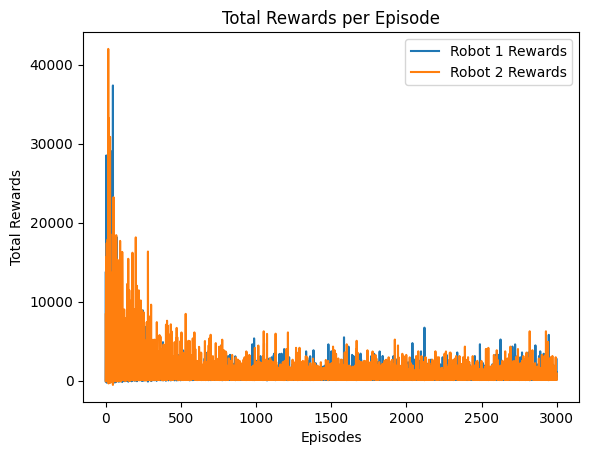

Best Path for Robot 1: [(9, 0), (9, 0), (9, 1), (8, 1), (8, 2), (7, 2), (7, 3), (7, 3), (7, 4), (6, 4), (7, 4), (6, 4), (7, 4), (6, 4), (6, 4), (6, 4), (6, 5), (6, 6), (5, 6), (5, 7), (5, 8), (5, 9), (4, 9), (3, 9), (2, 9), (3, 9), (2, 9), (1, 9), (2, 9), (2, 9), (1, 9), (0, 9), (0, 9), (0, 9), (0, 9), (0, 9), (0, 9), (0, 9)]
Best Path for Robot 2: [(9, 1), (9, 2), (8, 2), (7, 2), (7, 3), (7, 4), (6, 4), (6, 4), (6, 4), (5, 4), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (4, 7), (4, 8), (5, 8), (5, 7), (5, 6), (6, 6), (6, 5), (6, 6), (5, 6), (5, 7), (5, 8), (5, 7), (4, 7), (5, 7), (5, 8), (5, 9), (5, 8), (5, 7), (4, 7), (3, 7), (2, 7), (1, 7), (0, 7)]


In [ ]:
# Example grid setup
grid = np.zeros((10, 10))
grid[1][3] = 1  # Obstacle
grid[2][3] = 1  # Obstacle
grid[3][3] = 1  # Obstacle
grid[3][2] = 1  # Obstacle

grid[4][6] = 1  # Obstacle
grid[3][6] = 1  # Obstacle
grid[7][7] = 1  # Obstacle
grid[8][7] = 1  # Obstacle
grid[6][3] = 1  # Obstacle
grid[7][1] = 1  # Obstacle
grid[2][8] = 1  # Obstacle



start1 = (9, 0)
goal1 = (0, 9)
start2 = (9, 1)
goal2 = (0, 7)

# Initialize QL agent
QL_agent = QL(grid, start1, start2, goal1, goal2)

# Train QL agent
total_rewards1, total_rewards2, total_steps1, total_steps2, total_collisions, episodes, best_path1, best_path2 = QL_agent.train(episodes=3000)

# Log the metrics
QL_agent.log_metrics(total_steps1, total_steps2, total_collisions, episodes)

# Plot the rewards graph
QL_agent.plot_rewards(total_rewards1, total_rewards2)

# Print the best path for Robot 1 and Robot 2
print("Best Path for Robot 1:", best_path1)
print("Best Path for Robot 2:", best_path2)


In [ ]:
# Log the metrics
QL_agent.log_metrics(total_steps1, total_steps2, total_collisions, episodes)

Metrics after training:
Average steps for Robot 1: 56.65
Average steps for Robot 2: 56.65
Average collisions: 1.33


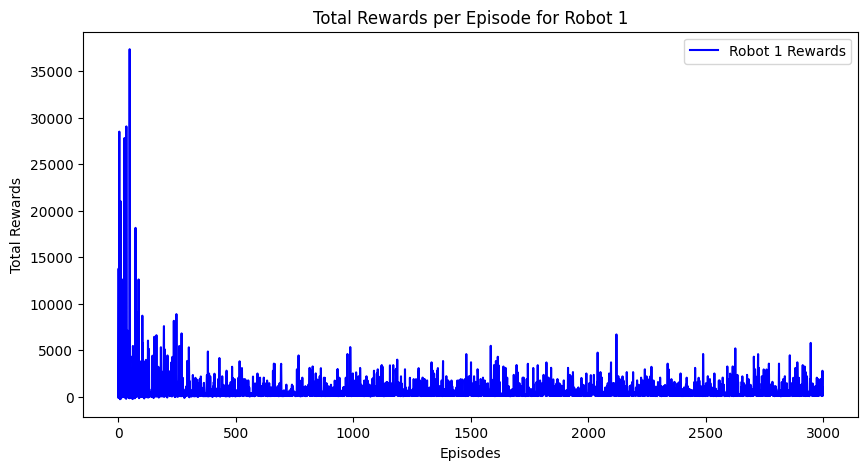

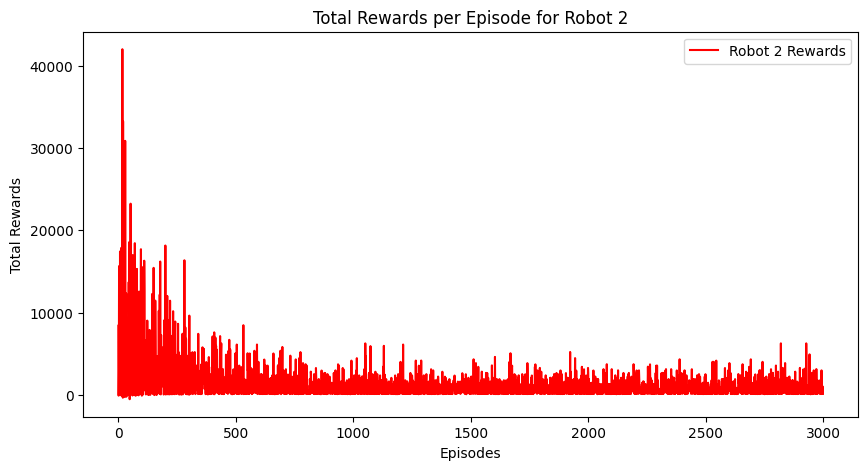

In [ ]:
    # Plot individual reward graph for Robot 1
    plt.figure(figsize=(10, 5))
    plt.plot(total_rewards1, label="Robot 1 Rewards", color='blue')
    plt.xlabel("Episodes")
    plt.ylabel("Total Rewards")
    plt.title("Total Rewards per Episode for Robot 1")
    plt.legend()
    plt.show()

    # Plot individual reward graph for Robot 2
    plt.figure(figsize=(10, 5))
    plt.plot(total_rewards2, label="Robot 2 Rewards", color='red')
    plt.xlabel("Episodes")
    plt.ylabel("Total Rewards")
    plt.title("Total Rewards per Episode for Robot 2")
    plt.legend()
    plt.show()


In [ ]:
from matplotlib import animation
from matplotlib.colors import ListedColormap


# Updated Animation Function
def animate_paths(grid, robot1_paths, robot2_paths, goal1, goal2, filename):
    fig, ax = plt.subplots()
    cmap = ListedColormap(["white", "black", "green", "blue", "red"])
    ax.imshow(grid, cmap=cmap, origin="upper")
    ax.set_xticks(range(grid.shape[1]))
    ax.set_yticks(range(grid.shape[0]))
    ax.grid(color='gray', linestyle='-', linewidth=0.5)

    # Initialize plot elements
    robot1, = ax.plot([], [], "bo", markersize=10, label="Robot 1")
    robot2, = ax.plot([], [], "ro", markersize=10, label="Robot 2")
    ax.plot(goal1[1], goal1[0], "g*", markersize=15, label="Goal 1")
    ax.plot(goal2[1], goal2[0], "y*", markersize=15, label="Goal 2")
    ax.legend()

    def init():
        robot1.set_data([], [])
        robot2.set_data([], [])
        return robot1, robot2

    def update(frame):
        # Ensure we do not exceed path length
        frame = min(frame, len(robot1_paths) - 1, len(robot2_paths) - 1)
        robot1.set_data(robot1_paths[frame][1], robot1_paths[frame][0])
        robot2.set_data(robot2_paths[frame][1], robot2_paths[frame][0])
        return robot1, robot2

    # Create animation
    ani = animation.FuncAnimation(
        fig, update, frames=max(len(robot1_paths), len(robot2_paths)),
        init_func=init, blit=True, interval=1000
    )

    # Save animation as video
    writer = animation.FFMpegWriter(fps=1)
    ani.save(filename, writer=writer)
    plt.close(fig)
    print(f"Animation saved to {filename}!")


In [ ]:
# Animate and Save Videos
animate_paths(grid, astar_path1, astar_path2, goal1, goal2, "Astar_best_path.mp4")
animate_paths(grid, best_path1, best_path2, goal1, goal2, "QL_best_path.mp4")


<ipython-input-49-89ead11a7301>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  robot1.set_data(robot1_paths[frame][1], robot1_paths[frame][0])


Animation saved to Astar_best_path.mp4!


<ipython-input-49-89ead11a7301>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  robot1.set_data(robot1_paths[frame][1], robot1_paths[frame][0])


Animation saved to QL_best_path.mp4!


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



--- Comparison of A* and QL ---

Algorithm         | Steps (R1, R2)                   | Collisions             | Total Reward (R1, R2)                      | Computation Time (s)
------------------|----------------------------------|------------------------|--------------------------------------------|----------------------
A*                | (9, 8) | N/A                    | N/A                                        | 0.00
QL             | (55505, 55505)     | 1564       | (510802, 877129) | 0.95


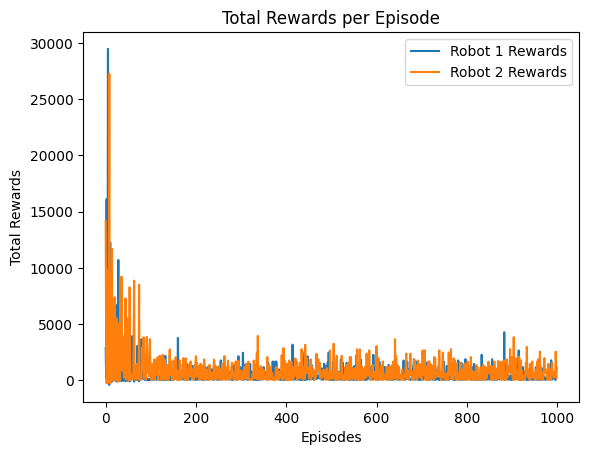

In [ ]:
import time

# Run QL
start_time_QL = time.time()
QL_agent = QL(grid, start1, start2, goal1, goal2)
QL_rewards1, QL_rewards2, QL_steps1, QL_steps2, QL_collisions, QL_episodes, QL_path1, QL_path2 = QL_agent.train(episodes=1000)
end_time_QL= time.time()

QL_time = end_time_QL - start_time_QL

# Run A*
start_time_astar = time.time()
astar_path1, astar_path2 = astar(start1, start2, goal1, goal2, grid)
end_time_astar = time.time()

astar_time = end_time_astar - start_time_astar

# Calculate steps for A*
astar_steps1 = len(astar_path1) - 1 if astar_path1 else float('inf')
astar_steps2 = len(astar_path2) - 1 if astar_path2 else float('inf')

# Display the comparison
print("\n--- Comparison of A* and QL ---\n")
print(f"Algorithm         | Steps (R1, R2)                   | Collisions             | Total Reward (R1, R2)                      | Computation Time (s)")
print(f"------------------|----------------------------------|------------------------|--------------------------------------------|----------------------")
print(f"A*                | ({astar_steps1}, {astar_steps2}) | N/A                    | N/A                                        | {astar_time:.2f}")
print(f"QL             | ({QL_steps1}, {QL_steps2})     | {QL_collisions}       | ({sum(QL_rewards1)}, {sum(QL_rewards2)}) | {QL_time:.2f}")

# Plot rewards for QL
QL_agent.plot_rewards(QL_rewards1, QL_rewards2)




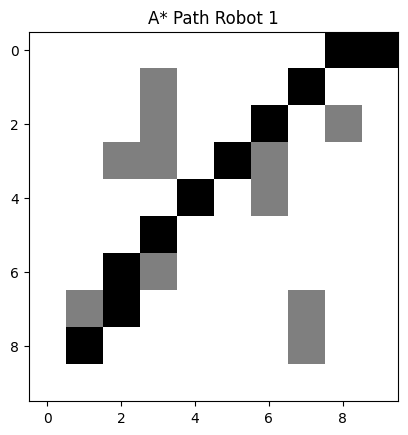

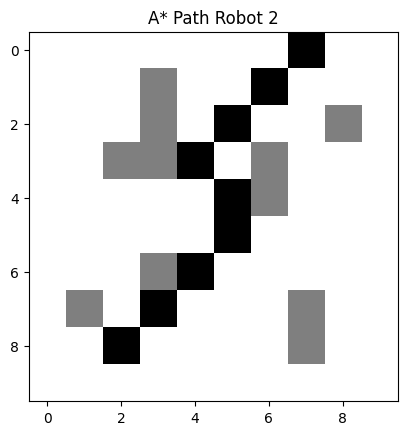

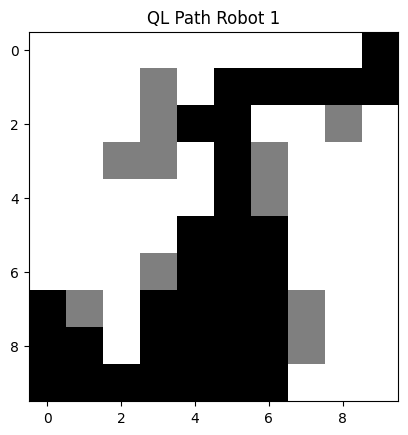

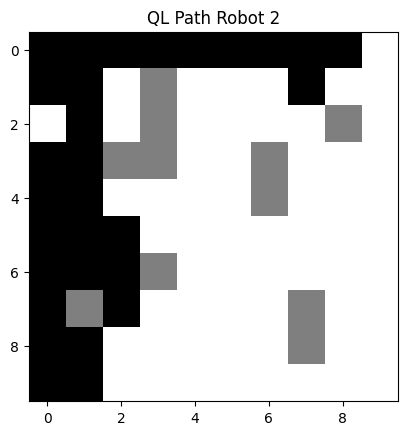

In [ ]:
# Visualize paths
def visualize_paths(grid, paths, titles):
    for path, title in zip(paths, titles):
        grid_copy = grid.copy()
        for position in path:
            grid_copy[position] = 2  # Mark path with 2
        plt.imshow(grid_copy, cmap='binary')
        plt.title(title)
        plt.show()

visualize_paths(grid, [astar_path1, astar_path2, QL_path1, QL_path2],
                ["A* Path Robot 1", "A* Path Robot 2", "QL Path Robot 1", "QL Path Robot 2"])


--- Detailed Comparison Table ---

                 Metric         A*  QL (Best)
0       Steps (Robot 1)  10.000000  66.000000
1       Steps (Robot 2)   9.000000  66.000000
2  Computation Time (s)   0.001863   5.175458


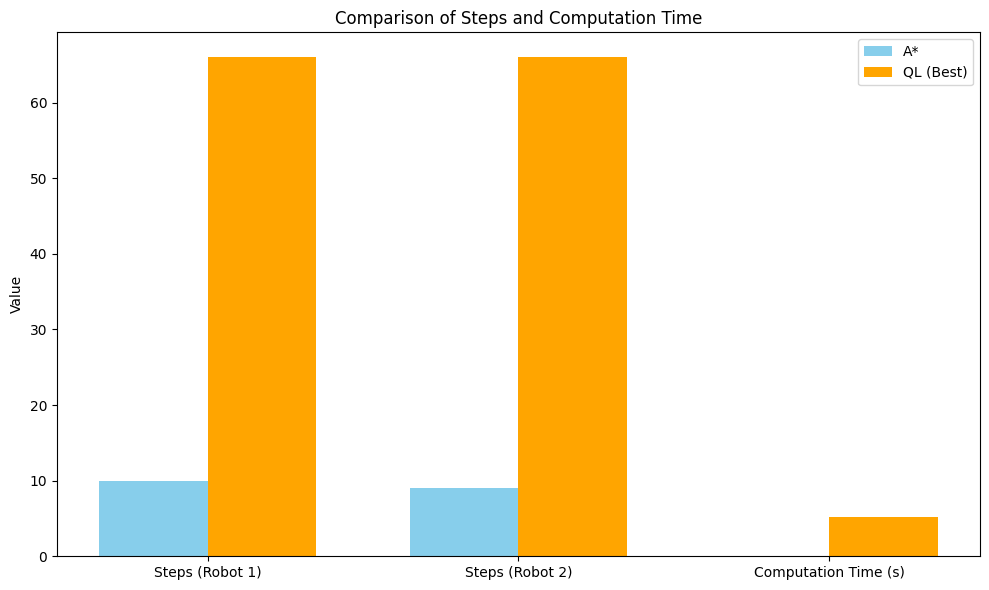

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate steps for QL using best paths
QL_best_steps1 = len(best_path1)
QL_best_steps2 = len(best_path2)

# Metrics for comparison
comparison_data = {
    "Metric": ["Steps (Robot 1)", "Steps (Robot 2)", "Computation Time (s)"],
    "A*": [len(astar_path1), len(astar_path2), astar_time],
    "QL (Best)": [QL_best_steps1, QL_best_steps2, QL_time],
}

# Convert data to a DataFrame for display
comparison_df = pd.DataFrame(comparison_data)
print("\n--- Detailed Comparison Table ---\n")
print(comparison_df)

# Plot bar charts for steps and computation time
metrics = ["Steps (Robot 1)", "Steps (Robot 2)", "Computation Time (s)"]
values_astar = [len(astar_path1), len(astar_path2), astar_time]
values_QL_best = [QL_best_steps1, QL_best_steps2, QL_time]

fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(metrics))
bar_width = 0.35
ax.bar(x, values_astar, bar_width, label="A*", color="skyblue")
ax.bar([p + bar_width for p in x], values_QL_best, bar_width, label="QL (Best)", color="orange")

ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(metrics)
ax.set_ylabel("Value")
ax.set_title("Comparison of Steps and Computation Time")
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Compute Path Optimality for A* and QL
astar_optimality1 = len(astar_path1) / len(astar_path1)  # A* path is assumed optimal
astar_optimality2 = len(astar_path2) / len(astar_path2)
QL_optimality1 = len(best_path1) / len(astar_path1)
QL_optimality2 = len(best_path2) / len(astar_path2)

# Compute Collision Rate for QL
collision_rate = total_collisions / episodes  # Ensure episodes is an integer

# Compute Success Rate
QL_success_rate = 1  # QL reached the goal in the best paths
astar_success_rate = 1  # A* always reaches the goal

# Learning Efficiency (QL)
learning_rate = (sum(total_rewards1[-100:]) + sum(total_rewards2[-100:])) - \
                (sum(total_rewards1[:100]) + sum(total_rewards2[:100]))  # Change in rewards

# Comparison Data
comparison_data = {
    "Metric": ["Optimality (Robot 1)", "Optimality (Robot 2)",
               "Collision Rate", "Success Rate", "Learning Rate"],
    "A*": [astar_optimality1, astar_optimality2, "N/A", astar_success_rate, "N/A"],
    "QL": [QL_optimality1, QL_optimality2, collision_rate, QL_success_rate, learning_rate],
}

# Convert data to a DataFrame for display
comparison_df = pd.DataFrame(comparison_data)
print("\n--- Detailed Comparison Table ---\n")
print(comparison_df)





--- Detailed Comparison Table ---

                 Metric   A*            QL
0  Optimality (Robot 1)  1.0  6.600000e+00
1  Optimality (Robot 2)  1.0  7.333333e+00
2        Collision Rate  N/A  2.595000e+00
3          Success Rate    1  1.000000e+00
4         Learning Rate  N/A -2.034098e+06


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


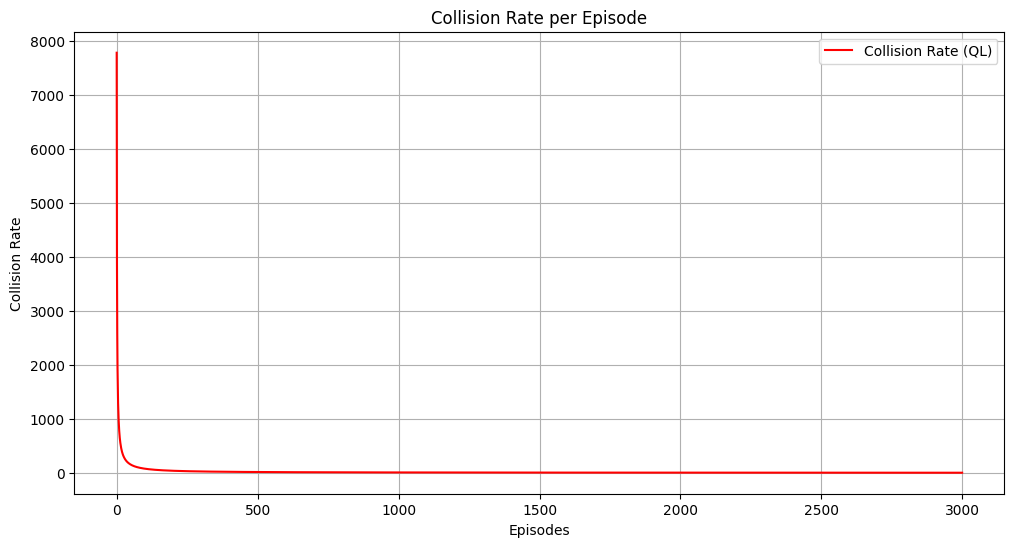

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `total_collisions` is the count of collisions in QL
# Assuming `episodes` is the total number of episodes
collision_rate_per_episode = [total_collisions / (i + 1) for i in range(len(total_rewards1))]

# Compute Learning Efficiency (difference in rewards over episodes)
learning_efficiency = []
window_size = 100  # Rolling window for smoother graph
for i in range(len(total_rewards1)):
    if i >= window_size:
        past_rewards = sum(total_rewards1[i - window_size:i]) + sum(total_rewards2[i - window_size:i])
        current_rewards = sum(total_rewards1[i - window_size + 1:i + 1]) + sum(total_rewards2[i - window_size + 1:i + 1])
        efficiency = current_rewards - past_rewards
        learning_efficiency.append(efficiency)

# Plot Collision Rate
plt.figure(figsize=(12, 6))
plt.plot(range(len(total_rewards1)), collision_rate_per_episode, label="Collision Rate (QL)", color="red")
plt.title("Collision Rate per Episode")
plt.xlabel("Episodes")
plt.ylabel("Collision Rate")
plt.legend()
plt.grid(True)
plt.show()



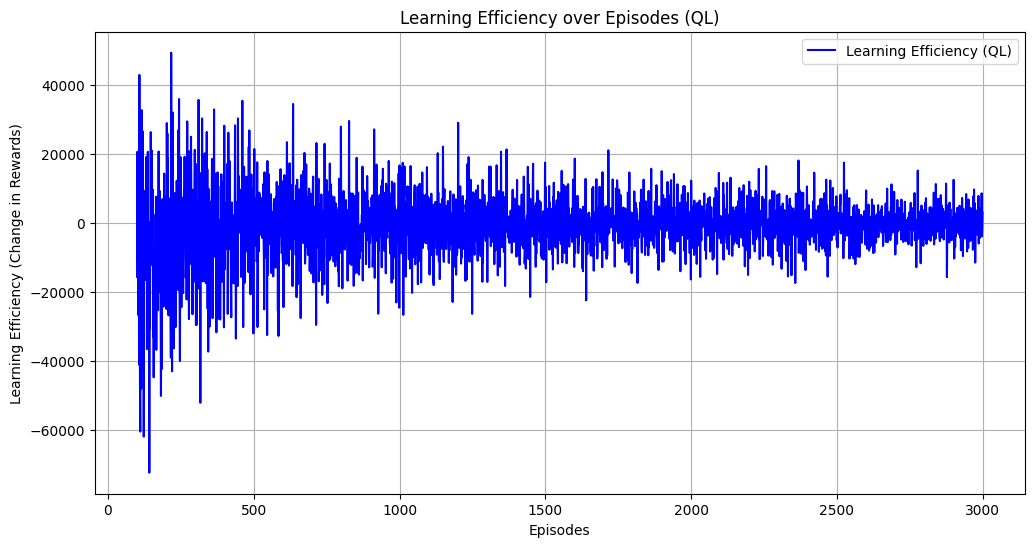

In [ ]:

# Plot Learning Efficiency
plt.figure(figsize=(12, 6))
plt.plot(range(window_size, len(total_rewards1)), learning_efficiency, label="Learning Efficiency (QL)", color="blue")
plt.title("Learning Efficiency over Episodes (QL)")
plt.xlabel("Episodes")
plt.ylabel("Learning Efficiency (Change in Rewards)")
plt.legend()
plt.grid(True)
plt.show()